In [1]:
import os
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import product
from tqdm.auto import tqdm
from datasets import available_datasets

sns.set_style('whitegrid')
sns.set_context("talk")
pd.set_option('display.width', 2000)

## Helper Functions

In [2]:
def read_logs(path, **kwargs):
    arg_names = kwargs.keys()
    arg_values = kwargs.values()
    configs = list(product(*arg_values))

    df_results = pd.DataFrame()
    
    for config in tqdm(configs):
        experiment_dir = os.path.join(
            path,
            *[f'{arg}:{val}' for arg, val in zip(arg_names, config)]
        )

        event_file = os.path.join(experiment_dir, 'metrics.csv')
        df = pd.read_csv(event_file)

        for arg, val in zip(arg_names, config):
            df[arg] = val
            
        df_results = df_results.append(df, ignore_index=True)

    return df_results


def explode(df, col, val):
    df[col] = [val for _ in range(len(df))]
    df = df.explode(col, ignore_index=True)
    return df


def export_figure(path, df, x, y, hue, row, col, group, error=None):
    if not os.path.exists(path):
        os.makedirs(path)
    
    if error is None:
        df = df.groupby([group, row, col, hue, x])[y].agg(['mean', np.std]).reset_index()
        output = [x, 'mean', 'std']
    else:
        output = [x, y, error]
        
    df['filename'] = df[[group, row, col, hue]].apply(lambda row: '-'.join(row.astype(str)) + f'-{x}.txt', axis=1)
    df.groupby('filename').apply(
        lambda row: row[output].to_csv(
            os.path.join(path, row['filename'].unique().item()), 
            index=None, 
            sep=' '
        )
    )
    

def latex_output(df_results, top_method, colored_method=None, color=None, size=None):
    if size is not None:
        df_results = df_results.applymap(lambda x: f'{{{size} {x}}}')
        
    if color is not None:
        df_results.loc[pd.IndexSlice[:, 'DPGNN'], :] = df_results.loc[pd.IndexSlice[:, 'DPGNN'], :].applymap(
            lambda x: f'\textcolor{{{color}}}{{{x}}}'
        )
        
    # print latex code
    cols = df_results.shape[1] + 2
    latex = df_results.to_latex(escape=False)
    for line in latex.splitlines():
        if line.find(top_method + ' ') == -1:
            print(line)
        else:
            print('\\midrule')
            print(line)

## Datasets

In [3]:
datasets = set(available_datasets())

## Analysis of the utility-privacy trade-off

In [5]:
epsilons = [0.01, 0.1, 0.5, 1.0, 2.0]

df_lpgnn = read_logs(
    path='results/',
    task=['train'],
    dataset=datasets, 
    labelrate=[1.0],
    method=['mbm'], 
    eps=epsilons,
    step=[1,2,4,8,16,32],
    agg=['gcn'],
    selfloops=[False],
)

df_gcn = read_logs(
    path='results/',
    task=['train'],
    dataset=datasets, 
    labelrate=[1.0],
    method=['raw'], 
    eps=[0],
    step=[1],
    agg=['gcn'],
    selfloops=[True],
)

df_rnd = read_logs(
    path='results/',
    task=['train'],
    dataset=datasets, 
    labelrate=[1.0],
    method=['rnd'], 
    eps=[0],
    step=[1],
    agg=['gcn'],
    selfloops=[True],
)

df_gcn = explode(df_gcn, col='eps', val=epsilons)
df_rnd = explode(df_rnd, col='eps', val=epsilons)

In [6]:
names = {
    'raw': '1-GCN+Raw',
    'mbm': '2-DPGNN',
    'rnd': '3-GCN+Rnd',
    'cora': '1-Cora',
    'citeseer': '2-Citeseer',
    'pubmed': '3-Pubmed',
    'facebook': '4-Facebook',
    'github': '5-Github',
    'lastfm': '6-LastFM'
}
df_mean = df_lpgnn.groupby(['dataset', 'eps', 'step'])['test_acc'].mean().reset_index()
idx = df_mean.groupby(['dataset', 'eps'])['test_acc'].transform(max) == df_mean['test_acc']
df_max = df_mean[idx]
df_final = df_lpgnn.merge(df_max.drop(columns='test_acc'), on=['dataset', 'eps', 'step'], how='inner')
data = df_final.append(df_gcn, ignore_index=True).append(df_rnd, ignore_index=True)
data = data.groupby(['dataset', 'method', 'eps']).agg({'test_acc': ['mean', lambda x: np.std(x)]}).reset_index()
data = data.replace(names)
data.columns = ['Dataset', 'Method', '$\epsilon$', 'mean', 'std']
data['result'] = data[['mean', 'std']].apply(lambda row: '%.1f $\pm$ %.1f' % (row['mean'], row['std']), axis=1)
data = data.drop(columns=['mean', 'std']).set_index(['Dataset', 'Method', '$\epsilon$'])
data = data.unstack()
data = data.rename(index=lambda name: name[2:] if name[1] == '-' else name)
data
# latex_output(data, top_method='GCN+Raw', size='\scriptsize', color='blue', colored_method='DPGNN')

result                                                                
$\epsilon$                  0.01            0.10            0.50            1.00            2.00
Dataset  Method                                                                                 
Cora     GCN+Raw  85.6 $\pm$ 0.5  85.6 $\pm$ 0.5  85.6 $\pm$ 0.5  85.6 $\pm$ 0.5  85.6 $\pm$ 0.5
         DPGNN    85.6 $\pm$ 1.0  86.9 $\pm$ 0.6  85.6 $\pm$ 0.7  85.3 $\pm$ 0.6  86.1 $\pm$ 0.5
         GCN+Rnd  74.7 $\pm$ 1.9  74.7 $\pm$ 1.9  74.7 $\pm$ 1.9  74.7 $\pm$ 1.9  74.7 $\pm$ 1.9
Citeseer GCN+Raw  73.6 $\pm$ 0.6  73.6 $\pm$ 0.6  73.6 $\pm$ 0.6  73.6 $\pm$ 0.6  73.6 $\pm$ 0.6
         DPGNN    68.0 $\pm$ 1.0  69.1 $\pm$ 0.6  69.1 $\pm$ 0.5  67.6 $\pm$ 0.7  68.4 $\pm$ 0.5
         GCN+Rnd  55.2 $\pm$ 8.0  55.2 $\pm$ 8.0  55.2 $\pm$ 8.0  55.2 $\pm$ 8.0  55.2 $\pm$ 8.0
Pubmed   GCN+Raw  87.7 $\pm$ 0.2  87.7 $\pm$ 0.2  87.7 $\pm$ 0.2  87.7 $\pm$ 0.2  87.7 $\pm$ 0.2
         DPGNN    82.8 $\pm$ 0.3  82.4 $\pm$ 0.3  82.4 $\pm$ 0.3  82.3 $\pm$ 0.2  83.2 $\pm$ 0.3
         GCN+Rnd  55.5 $\pm$ 1.6  55.5 $\pm$ 1.6  55.5 $\pm$ 1.6  55.5 $\pm$ 1.6  55.5 $\pm$ 1.6
Facebook GCN+Raw  94.1 $\pm$ 0.2  94.1 $\pm$ 0.2  94.1 $\pm$ 0.2  94.1 $\pm$ 0.2  94.1 $\pm$ 0.2
         DPGNN    94.0 $\pm$ 0.1  93.9 $\pm$ 0.2  94.3 $\pm$ 0.1  93.6 $\pm$ 0.2  94.2 $\pm$ 0.1
         GCN+Rnd  38.9 $\pm$ 2.0  38.9 $\pm$ 2.0  38.9 $\pm$ 2.0  38.9 $\pm$ 2.0  38.9 $\pm$ 2.0
Github   GCN+Raw  86.1 $\pm$ 0.2  86.1 $\pm$ 0.2  86.1 $\pm$ 0.2  86.1 $\pm$ 0.2  86.1 $\pm$ 0.2
         DPGNN    85.9 $\pm$ 0.1  85.9 $\pm$ 0.2  85.7 $\pm$ 0.2  85.4 $\pm$ 0.1  86.1 $\pm$ 0.2
         GCN+Rnd  74.3 $\pm$ 0.0  74.3 $\pm$ 0.0  74.3 $\pm$ 0.0  74.3 $\pm$ 0.0  74.3 $\pm$ 0.0
LastFM   GCN+Raw  88.9 $\pm$ 0.4  88.9 $\pm$ 0.4  88.9 $\pm$ 0.4  88.9 $\pm$ 0.4  88.9 $\pm$ 0.4
         DPGNN    87.7 $\pm$ 0.3  88.0 $\pm$ 0.2  87.7 $\pm$ 0.2  87.4 $\pm$ 0.3  88.4 $\pm$ 0.3
         GCN+Rnd  21.0 $\pm$ 0.1  21.0 $\pm$ 0.1  21.0 $\pm$ 0.1  21.0 $\pm$ 0.1  21.0 $\pm$ 0.1

## Studying the effect of multi-bit mechanism

In [8]:
df_error = read_logs(
    path='results/', 
    task=['error'], 
    dataset=available_datasets(), 
    method=['obm', 'agm', 'mbm'], 
    eps=[0.1, 0.5, 1.0, 2.0], 
    agg=['gcn'], 
)

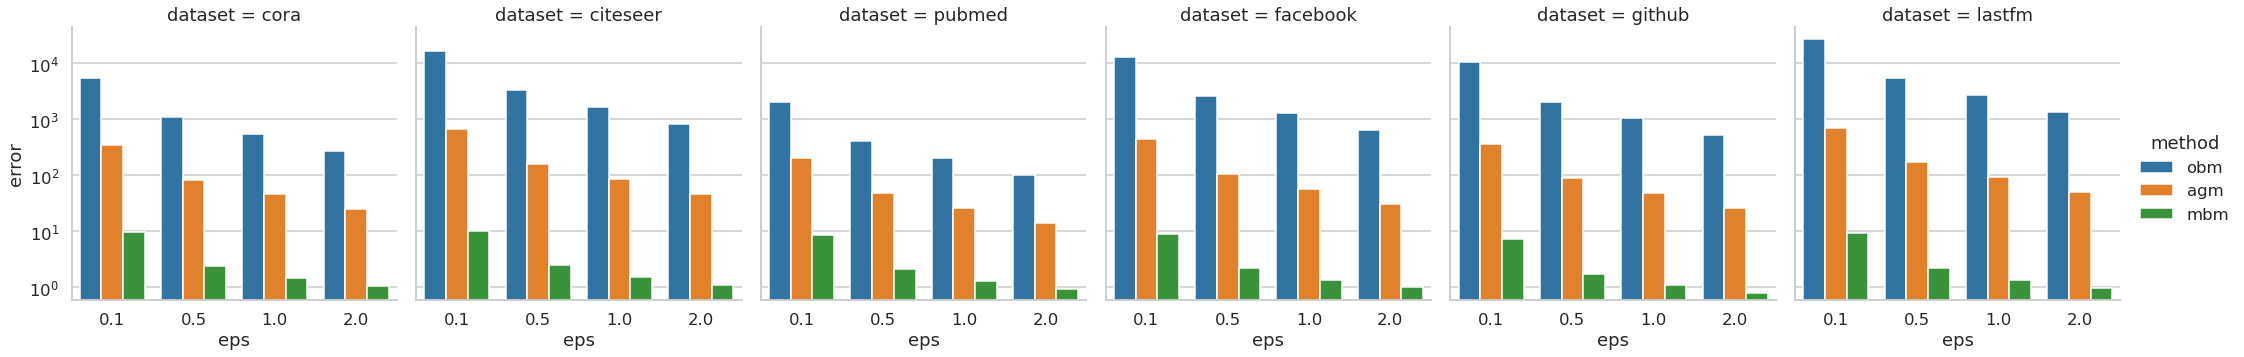

In [9]:
ax = sns.catplot(
    kind='bar', data=df_error, x='eps', y='error', hue='method', col='dataset', ci=None, sharey=True
)
ax.set(yscale='log')

# export_figure(
#     path='figures', df=df_error, x='eps', y='error', hue='method', 
#     col='dataset', row='agg', error='std', group='task'
# )

In [10]:
df_error = read_logs(
    path='results/', 
    task=['error'], 
    dataset=available_datasets(), 
    method=['mbm'], 
    eps=[0.1, 0.5, 1.0, 2.0], 
    agg=['mean', 'gcn'], 
)

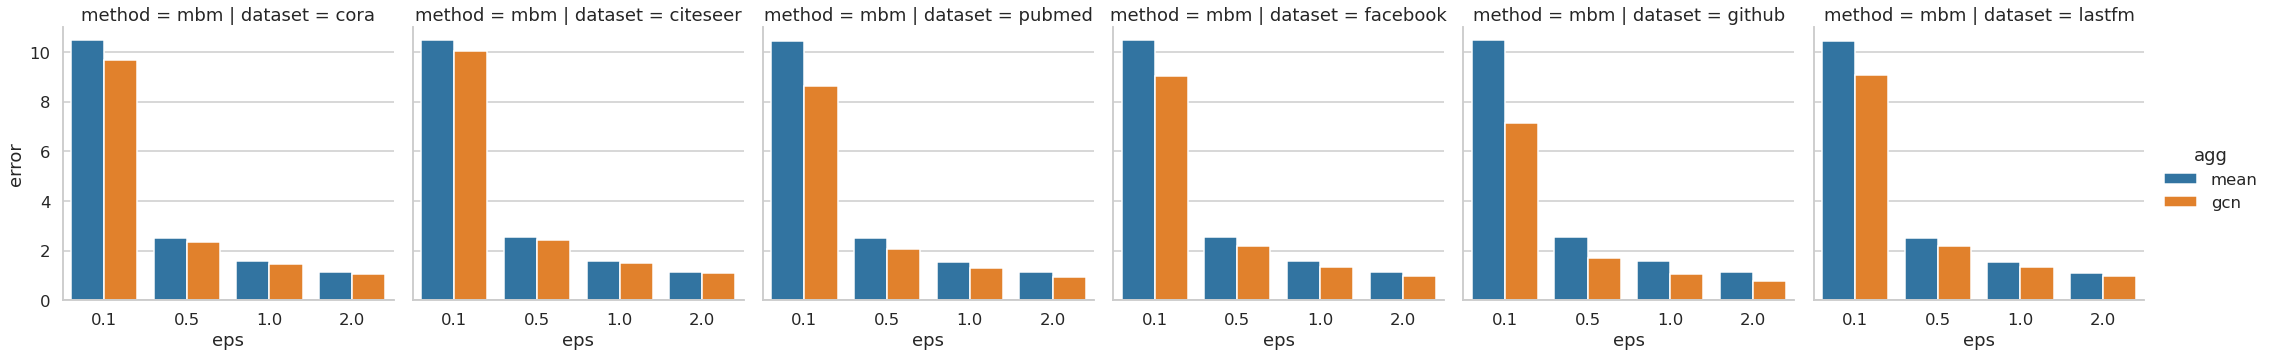

In [11]:
ax = sns.catplot(
    kind='bar', data=df_error, x='eps', y='error', hue='agg', col='dataset', row='method', ci=None, sharey=True
)

# export_figure(
#     path='figures', df=df_error, x='eps', y='error', hue='agg', 
#     col='dataset', row='method', error='std', group='task'
# )

## Studying the effect of KProp

In [12]:
epsilons = [0.01, 0.1, 1.0]
steps = [1, 2, 4, 8, 16, 32]

df_lpgnn = read_logs(
    path='results/',
    task=['train'],
    dataset=datasets, 
    labelrate=[1.0],
    method=['mbm'], 
    eps=epsilons,
    step=steps,
    agg=['gcn'],
    selfloops=[False],
)

df_gcn = read_logs(
    path='results/',
    task=['train'],
    dataset=datasets, 
    labelrate=[1.0],
    method=['raw'], 
    eps=[0],
    step=steps,
    agg=['gcn'],
    selfloops=[False],
)

data = df_lpgnn.append(df_gcn, ignore_index=True)

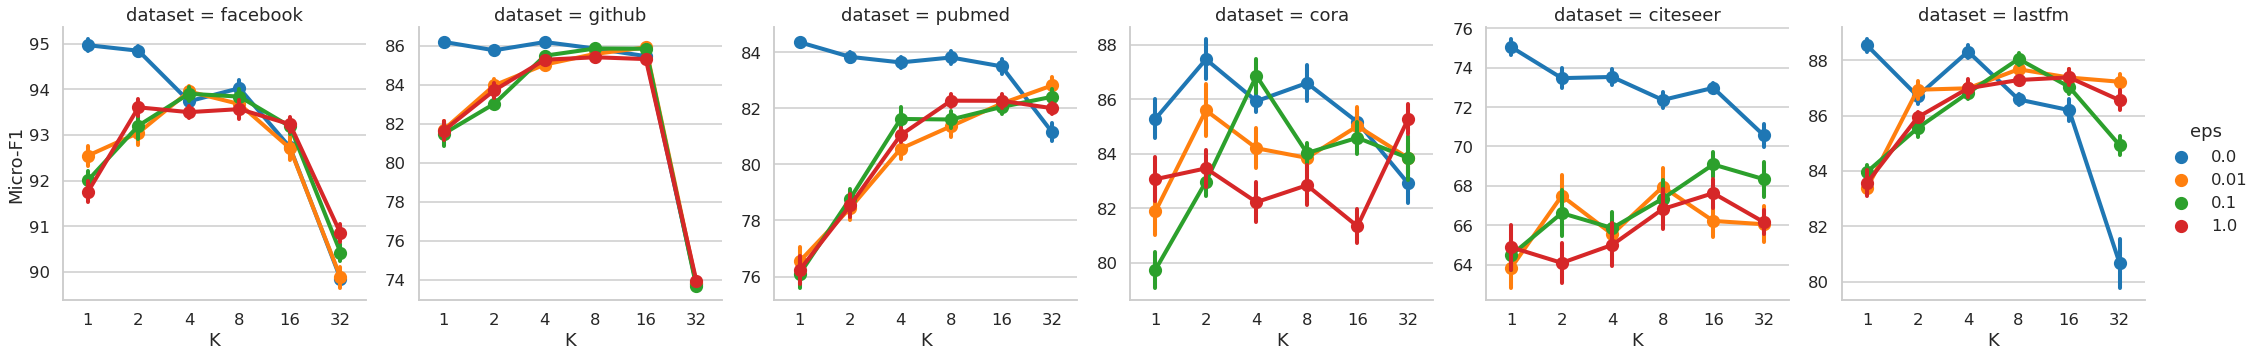

In [13]:
ax = sns.catplot(
    kind='point', data=data, x='step', y='test_acc', hue='eps', col='dataset', ci='sd',
    sharex=False, sharey=False,
)

ax.set_ylabels('Micro-F1')
ax.set_xlabels('K')

# export_figure(path='figures', df=data, x='hop', y='value', hue='eps', row='agg', col='dataset', group='task')

In [16]:
epsilons = [0.1]
steps = [1, 2, 4, 8, 16, 32]

data = read_logs(
    path='results/',
    task=['train'],
    dataset=datasets, 
    labelrate=[1.0],
    method=['mbm'], 
    eps=epsilons,
    step=steps,
    agg=['gcn'],
    selfloops=[False, True],
)

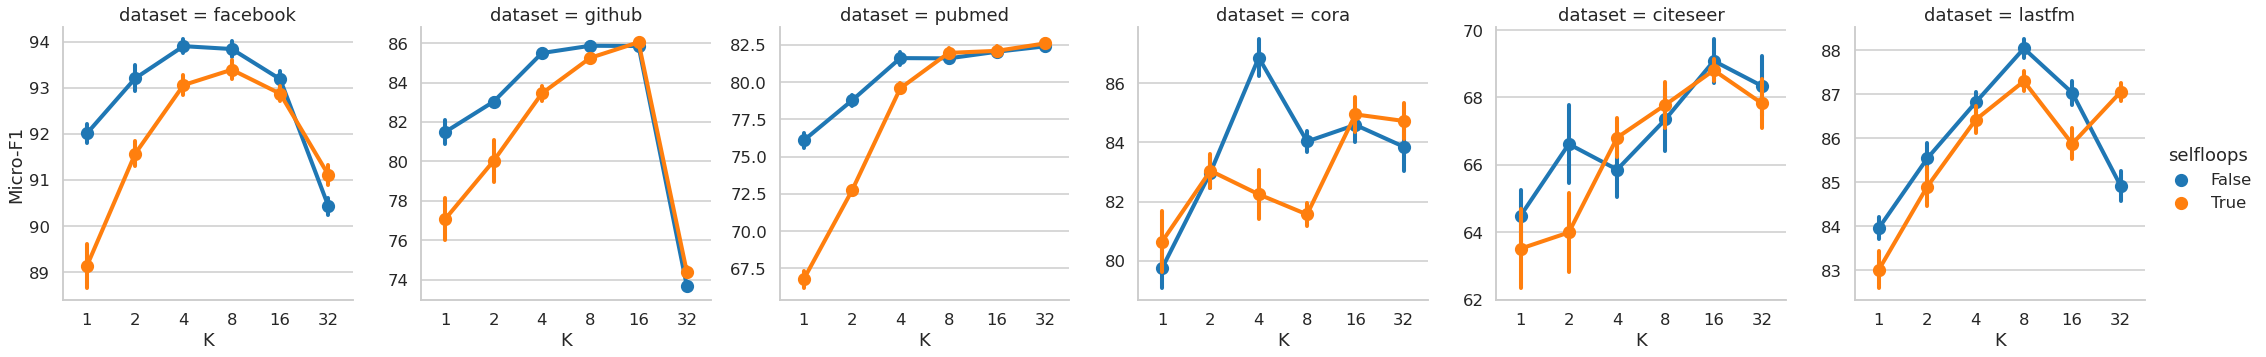

In [17]:
ax = sns.catplot(
    kind='point', data=data, x='step', y='test_acc', hue='selfloops', col='dataset', ci='sd',
    sharex=False, sharey=False,
)

ax.set_ylabels('Micro-F1')
ax.set_xlabels('K')

# export_figure(path='figures', df=data, x='hop', y='value', hue='loop', row='agg', col='dataset', group='task')

## Effect of label rate

In [9]:
datasets = available_datasets()

data = read_logs(
    path='results/',
    task=['train'],
    dataset=datasets, 
    labelrate=[0.2, 0.4, 0.6, 0.8, 1.0],
    method=['mbm'], 
    eps=[0.5, 1.0, 2.0],
    step=[8],
    agg=['gcn'],
    selfloops=[False],
)

FileNotFoundError: [Errno 2] No such file or directory: 'results/task:train/dataset:cora/labelrate:0.2/method:mbm/eps:0.5/step:8/agg:gcn/selfloops:False/metrics.csv'

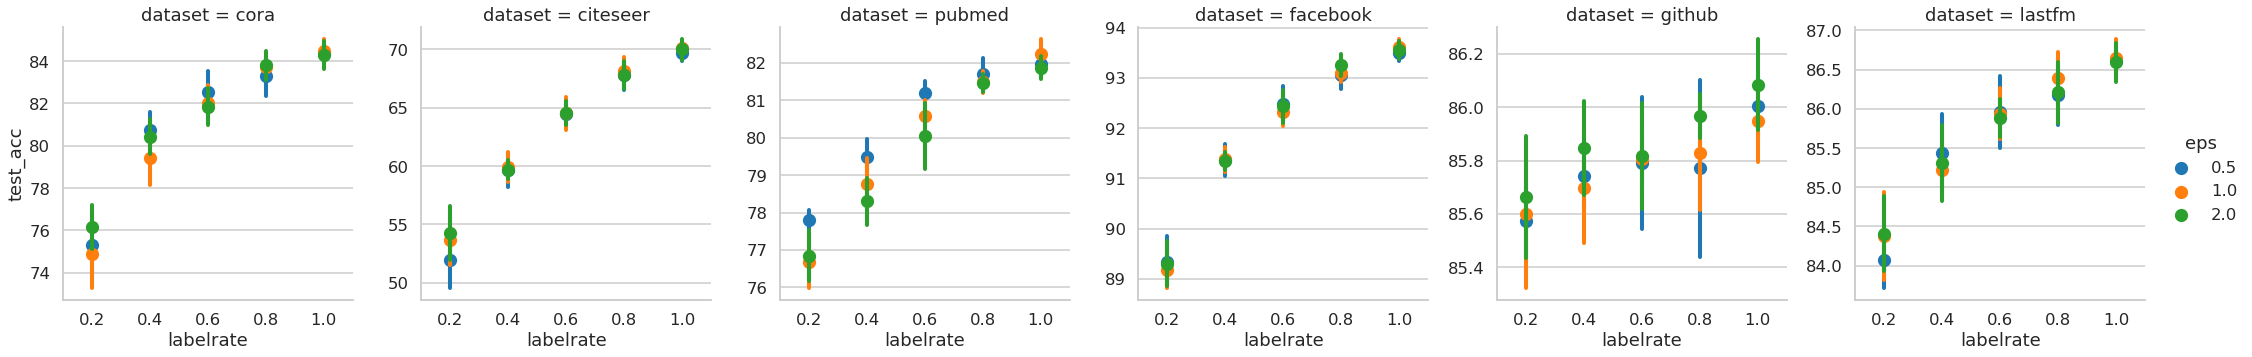

In [39]:
ax = sns.catplot(
    kind='point', data=data, x='labelrate', y='test_acc', hue='eps', col='dataset', ci='sd',
    sharex=False, sharey=False, join=False
)

# export_figure(path='figures', df=data, x='labelrate', y='value', hue='eps', row='agg', col='dataset', group='task')

In [40]:
datasets = available_datasets()

data = read_logs(
    path='results/',
    task=['train'],
    dataset=datasets, 
    labelrate=[0.2, 0.4, 0.6, 0.8, 1.0],
    method=['mbm'], 
    eps=[1.0],
    step=[2, 4, 8],
    agg=['gcn'],
    selfloops=[False],
)

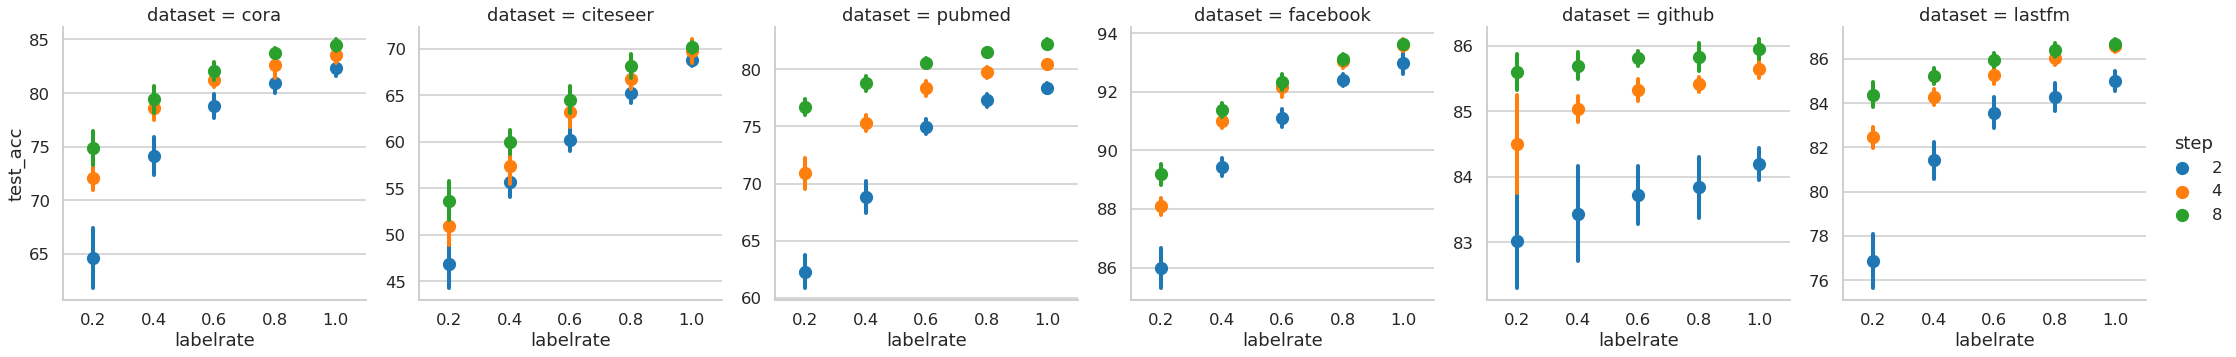

In [41]:
ax = sns.catplot(
    kind='point', data=data, x='labelrate', y='test_acc', hue='step', col='dataset', ci='sd',
    sharex=False, sharey=False, join=False
)

# ax.set(ylim=40)
# export_figure(path='figures', df=data, x='labelrate', y='value', hue='hop', row='agg', col='dataset', group='task')